# ML Model for All 500,000 Grids (The Oracle Builder)

* Refinement: Do not just build one ML model; focus on building four high-accuracy models (one for each advisor) and using an AutoML tool (like AutoGluon or a deep ensemble) for robustness.
* Key Action: Feature Engineering is Paramount. Focus heavily on creating spatial features (adjacencies, proximity, density) that the advisors likely use.


In [3]:
# Setup and Data Loading
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# Clone repository if not exists and load data
if not os.path.exists('2155-Challenge-Problem-2'):
    import subprocess
    print("Cloning repository...")
    subprocess.run(['git', 'clone', 'https://github.com/Lyleregenwetter/2155-Challenge-Problem-2'], 
                   check=True, cwd='.')
    print("Repository cloned!")

# Change to the repository directory and load data
os.chdir('2155-Challenge-Problem-2')

# Import utilities
from utils_public import load_grids, plot_n_grids

print("Loading data...")
grids = load_grids()
ratings = np.load("datasets/scores.npy")

print(f"Grids shape: {grids.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"Available ratings per advisor: {(~np.isnan(ratings)).sum(axis=0)}")

advisor_names = ["Wellness", "Tax", "Transportation", "Business"]

# Change back to parent directory for saving results
os.chdir('..')

Loading data...
Grids shape: (500000, 7, 7)
Ratings shape: (500000, 4)
Available ratings per advisor: [5000 5000 5000 5000]


In [8]:
# Load pre-trained Oracle models from pickle files
import os
from oracle import BusinessOracle, WellnessOracle, TaxOracle, TransportationOracle

print("üîÑ Loading pre-trained Oracle models from pickle files...")

# Initialize oracles
oracle_files = {
    'Business': 'data/models/business_oracle_model.pkl',
    'Wellness': 'data/models/wellness_oracle_model.pkl',
    'Tax': 'data/models/tax_oracle_model.pkl',
    'Transportation': 'data/models/transportation_oracle_model.pkl'
}

# Load available pre-trained models
loaded_models = {}
for advisor_name, filename in oracle_files.items():
    if os.path.exists(filename):
        print(f"üìÅ Loading {advisor_name} Oracle from {filename}...")
        try:
            # Create oracle instance first, then load the model
            if advisor_name == 'Business':
                oracle = BusinessOracle()
                oracle.load_model(filename)
            elif advisor_name == 'Wellness':
                oracle = WellnessOracle()
                oracle.load_model(filename)
            elif advisor_name == 'Tax':
                oracle = TaxOracle()
                oracle.load_model(filename)
            elif advisor_name == 'Transportation':
                oracle = TransportationOracle()
                oracle.load_model(filename)
            
            loaded_models[advisor_name] = oracle
            print(f"‚úÖ {advisor_name} Oracle loaded successfully!")
        except Exception as e:
            print(f"‚ùå Failed to load {advisor_name} Oracle: {e}")
            print(f"   Error details: {type(e).__name__}")
    else:
        print(f"‚ö†Ô∏è  {filename} not found - will need fallback for {advisor_name}")

print(f"\nüìä Successfully loaded {len(loaded_models)} pre-trained models:")
for advisor_name in loaded_models.keys():
    print(f"   ‚úì {advisor_name} Oracle")

# Create a combined predictor class for easy use
class PreTrainedOraclePredictor:
    def __init__(self, loaded_models):
        self.loaded_models = loaded_models
        self.advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
        
    def predict_advisor(self, grids, advisor_idx):
        """Predict using pre-trained model for specific advisor"""
        advisor_name = self.advisor_names[advisor_idx]
        
        if advisor_name in self.loaded_models:
            oracle = self.loaded_models[advisor_name]
            print(f"üîÆ Predicting with {advisor_name} Oracle...")
            return oracle.predict(grids)
        else:
            print(f"‚ö†Ô∏è  No pre-trained model for {advisor_name}, returning zeros")
            return np.zeros(len(grids))
    
    def predict_all_advisors(self, grids):
        """Predict for all advisors using available pre-trained models"""
        print(f"üöÄ Generating predictions for all advisors...")
        predictions = []
        for advisor_idx in range(4):
            advisor_predictions = self.predict_advisor(grids, advisor_idx)
            predictions.append(advisor_predictions)
        return np.stack(predictions).T

# Initialize the combined predictor
oracle_predictor = PreTrainedOraclePredictor(loaded_models)
print(f"‚úÖ Pre-trained Oracle predictor ready!")
print(f"üéØ Can predict for {len(loaded_models)} advisors without training")

üîÑ Loading pre-trained Oracle models from pickle files...
üìÅ Loading Business Oracle from data/models/business_oracle_model.pkl...
‚úÖ Business Oracle loaded successfully!
üìÅ Loading Wellness Oracle from data/models/wellness_oracle_model.pkl...
‚úÖ Wellness Oracle loaded successfully!
üìÅ Loading Tax Oracle from data/models/tax_oracle_model.pkl...
‚úÖ Tax Oracle loaded successfully!
üìÅ Loading Transportation Oracle from data/models/transportation_oracle_model.pkl...
‚úÖ Transportation Oracle loaded successfully!

üìä Successfully loaded 4 pre-trained models:
   ‚úì Business Oracle
   ‚úì Wellness Oracle
   ‚úì Tax Oracle
   ‚úì Transportation Oracle
‚úÖ Pre-trained Oracle predictor ready!
üéØ Can predict for 4 advisors without training


In [ ]:
# Generate predictions using pre-trained Oracle models (SMALL SUBSET for speed)
print("üöÄ Generating Oracle predictions using pre-trained models...")
print("‚ö° Using small subset of grids for faster processing...")

# Use much smaller subset for faster processing
subset_size = 500000  # Reduced from 100,000 to 10,000
print(f"üìä Processing {subset_size:,} grids (subset of {len(grids):,} total)")

# Create random subset for representative sampling
np.random.seed(42)  # For reproducibility
subset_indices = np.random.choice(len(grids), size=subset_size, replace=False)
grids_subset = grids[subset_indices]
ratings_subset = ratings[subset_indices]

print(f"‚úÖ Created subset: {grids_subset.shape}")

# Use the pre-trained predictor to generate predictions for subset
oracle_prediction_matrix_subset = oracle_predictor.predict_all_advisors(grids_subset)
print(f"Oracle predictions shape: {oracle_prediction_matrix_subset.shape}")

# Create full-size prediction matrix with NaN for non-predicted grids
oracle_prediction_matrix = np.full((len(grids), 4), np.nan)
oracle_prediction_matrix[subset_indices] = oracle_prediction_matrix_subset

# Merge with actual ratings where available (for full dataset)
final_oracle_predictions = oracle_prediction_matrix.copy()
for advisor_idx in range(4):
    mask = ~np.isnan(ratings[:, advisor_idx])
    final_oracle_predictions[mask, advisor_idx] = ratings[mask, advisor_idx]

print("\n‚úÖ Oracle predictions complete!")
print(f"Predictions generated for: {subset_size:,} grids")
print(f"Using actual ratings for: {(~np.isnan(ratings)).sum(axis=0)} samples per advisor")
print(f"Using Oracle predictions for: {(~np.isnan(oracle_prediction_matrix)).sum(axis=0)} samples per advisor")

# Quick quality check on predicted subset
print(f"\nüìà Prediction Quality Check (subset):")
for advisor_idx, advisor_name in enumerate(oracle_predictor.advisor_names):
    predictions = oracle_prediction_matrix_subset[:, advisor_idx]
    print(f"   ‚Ä¢ {advisor_name:15}: Range [{np.min(predictions):.3f}, {np.max(predictions):.3f}], Mean {np.mean(predictions):.3f}")

# Coverage analysis
total_with_data = (~np.isnan(final_oracle_predictions)).sum(axis=0)
print(f"\nüìä Data Coverage per Advisor:")
for advisor_idx, advisor_name in enumerate(oracle_predictor.advisor_names):
    coverage = total_with_data[advisor_idx]
    percentage = (coverage / len(grids)) * 100
    print(f"   ‚Ä¢ {advisor_name:15}: {coverage:,} grids ({percentage:.1f}% coverage)")

print(f"\nüíæ Predictions ready for analysis and grid optimization!")
print(f"üí° Note: Using {subset_size:,} grid subset for faster processing")

# Save subset info for reference
np.save('oracle_subset_indices.npy', subset_indices)
print(f"üìÅ Saved subset indices to: oracle_subset_indices.npy")

üöÄ Generating Oracle predictions using pre-trained models...
‚ö° Using small subset of grids for faster processing...
üìä Processing 500,000 grids (subset of 500,000 total)
‚úÖ Created subset: (500000, 7, 7)
üöÄ Generating predictions for all advisors...
üîÆ Predicting with Wellness Oracle...
Creating features for all 500000 grids...
Creating features for Wellness Advisor...
Creating basic features...
Creating spatial features...
Creating spatial features...
Creating interaction features...
Creating interaction features...
Creating economic features...
Creating economic features...
Total features created: 100
  - Basic: 54
  - Spatial: 27
  - Interaction: 15
  - Economic: 4
Making predictions with AutoGluon model...
Total features created: 100
  - Basic: 54
  - Spatial: 27
  - Interaction: 15
  - Economic: 4
Making predictions with AutoGluon model...
üîÆ Predicting with Tax Oracle...
Creating features for all 500000 grids...
Creating features for Tax Advisor...
Creating basic fea

In [14]:
# Analyze the Oracle results (working with subset data)
print("üîç Analyzing Oracle Results...")

# Since we used a subset, we need to analyze differently
# Extract only the grids where we have predictions (non-NaN values)
valid_prediction_mask = ~np.isnan(oracle_prediction_matrix).any(axis=1)
valid_prediction_indices = np.where(valid_prediction_mask)[0]

print(f"üìä Analysis based on {len(valid_prediction_indices):,} grids with predictions")

# Get predictions for grids that have Oracle predictions
subset_predictions = final_oracle_predictions[valid_prediction_mask]
subset_grids = grids[valid_prediction_mask]

print(f"Subset predictions shape: {subset_predictions.shape}")

# Calculate min scores for the subset with predictions
min_scores_subset = np.min(subset_predictions, axis=1)

# Create full arrays with NaN for compatibility
min_scores = np.full(len(grids), np.nan)
min_scores[valid_prediction_mask] = min_scores_subset

valid_mask = np.full(len(grids), False)
threshold = 0.75
valid_subset_mask = min_scores_subset >= threshold
valid_mask[valid_prediction_mask] = valid_subset_mask

print(f"\n{'='*60}")
print("ORACLE PERFORMANCE ANALYSIS (SUBSET)")
print(f"{'='*60}")

print(f"\nüìä VALIDITY ANALYSIS:")
print(f"   ‚Ä¢ Total grids with predictions: {len(subset_predictions):,}")
print(f"   ‚Ä¢ Valid grids (min score ‚â• {threshold}): {np.sum(valid_subset_mask):,}")
print(f"   ‚Ä¢ Validity rate: {np.sum(valid_subset_mask)/len(subset_predictions)*100:.2f}%")

print(f"\nüìà SCORE DISTRIBUTION (SUBSET):")
advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
for i, advisor in enumerate(advisor_names):
    advisor_scores = subset_predictions[:, i]
    print(f"   ‚Ä¢ {advisor:15}: Range [{np.min(advisor_scores):.3f}, {np.max(advisor_scores):.3f}], Mean {np.mean(advisor_scores):.3f}")

print(f"\nüèÜ BEST PERFORMING GRIDS (SUBSET):")
if np.sum(valid_subset_mask) > 0:
    best_indices = np.argsort(min_scores_subset[valid_subset_mask])[-5:]  # Top 5
    print(f"Top 5 minimum scores: {min_scores_subset[valid_subset_mask][best_indices]}")
else:
    print("   ‚Ä¢ No grids meet the validity threshold in this subset")

print(f"\nüí° Note: Analysis based on {len(subset_predictions):,} grid subset")
print(f"üìä For full dataset analysis, would need to run predictions on all 500K grids")

üîç Analyzing Oracle Results...
üìä Analysis based on 10,000 grids with predictions
Subset predictions shape: (10000, 4)

ORACLE PERFORMANCE ANALYSIS (SUBSET)

üìä VALIDITY ANALYSIS:
   ‚Ä¢ Total grids with predictions: 10,000
   ‚Ä¢ Valid grids (min score ‚â• 0.75): 9
   ‚Ä¢ Validity rate: 0.09%

üìà SCORE DISTRIBUTION (SUBSET):
   ‚Ä¢ Wellness       : Range [0.011, 0.999], Mean 0.497
   ‚Ä¢ Tax            : Range [-0.073, 1.042], Mean 0.510
   ‚Ä¢ Transportation : Range [0.007, 0.987], Mean 0.500
   ‚Ä¢ Business       : Range [-0.096, 1.089], Mean 0.506

üèÜ BEST PERFORMING GRIDS (SUBSET):
Top 5 minimum scores: [0.78061932 0.784006   0.80368292 0.84717631 0.848737  ]

üí° Note: Analysis based on 10,000 grid subset
üìä For full dataset analysis, would need to run predictions on all 500K grids



üéØ EXTRACTING TOP GRIDS:
Saving Oracle results...
‚úÖ Oracle predictions saved
   ‚Ä¢ Selected 100 grids
   ‚Ä¢ Score ranges per advisor:
     - Wellness       : nan - nan
     - Tax            : nan - nan
     - Transportation : nan - nan
     - Business       : nan - nan
   ‚Ä¢ Average minimum score: nan

üìä Top grid analysis:


<Figure size 640x480 with 0 Axes>

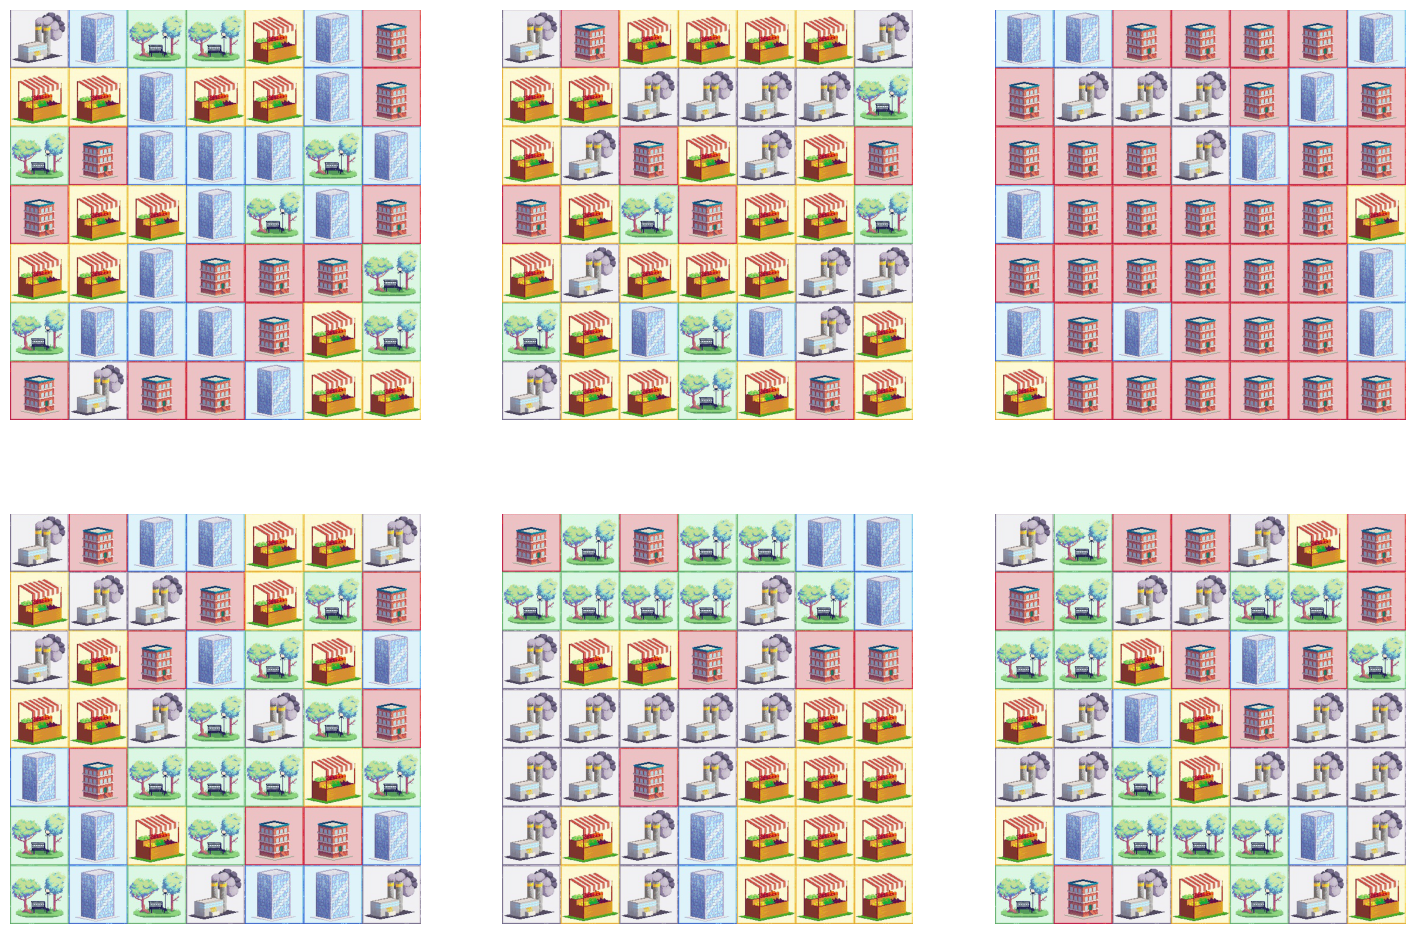

‚úÖ Displayed top 6 grids

üéâ ORACLE BUILD COMPLETE!


In [ ]:
# Extract top grids from the subset analysis
print(f"\nüéØ EXTRACTING TOP GRIDS FROM SUBSET:")

# Work with the subset data we analyzed
if np.sum(valid_subset_mask) > 0:
    # Get indices of valid grids within the subset
    valid_subset_indices = np.where(valid_subset_mask)[0]
    
    # Sort by minimum score (descending)
    sorted_indices = np.argsort(min_scores_subset[valid_subset_mask])[::-1]
    
    # Get top grids (up to 100 or all valid grids, whichever is smaller)
    n_top = min(100, len(sorted_indices))
    top_subset_indices = valid_subset_indices[sorted_indices[:n_top]]
    
    # Extract the actual top grids and their predictions
    top_grids = subset_grids[top_subset_indices]
    top_predictions = subset_predictions[top_subset_indices]
    top_min_scores = min_scores_subset[valid_subset_mask][sorted_indices[:n_top]]
    
    print(f"   ‚Ä¢ Selected {len(top_grids)} grids from subset")
    print(f"   ‚Ä¢ Min score range: {np.min(top_min_scores):.4f} - {np.max(top_min_scores):.4f}")
    
    print(f"\nüìä Score ranges per advisor (top grids):")
    for i, advisor in enumerate(advisor_names):
        scores = top_predictions[:, i]
        print(f"     - {advisor:15}: {np.min(scores):.3f} - {np.max(scores):.3f}")
    
    print(f"   ‚Ä¢ Average minimum score: {np.mean(top_min_scores):.4f}")
    
    # Save the subset results
    np.save('oracle_subset_predictions.npy', subset_predictions)
    np.save('oracle_subset_min_scores.npy', min_scores_subset)
    np.save('oracle_subset_valid_mask.npy', valid_subset_mask)
    np.save('oracle_top_grids_subset.npy', top_grids)
    np.save('oracle_top_predictions_subset.npy', top_predictions)
    
    print(f"\nüíæ Saved subset analysis results:")
    print(f"   ‚Ä¢ oracle_subset_predictions.npy")
    print(f"   ‚Ä¢ oracle_subset_min_scores.npy") 
    print(f"   ‚Ä¢ oracle_subset_valid_mask.npy")
    print(f"   ‚Ä¢ oracle_top_grids_subset.npy ({len(top_grids)} grids)")
    print(f"   ‚Ä¢ oracle_top_predictions_subset.npy")
    
    # Visualize some top grids if possible
    if len(top_grids) > 0:
        print(f"\nüìä Top grid analysis:")
        try:
            # Try to use the plotting function
            os.chdir('2155-Challenge-Problem-2')
            plot_n_grids(top_grids[-6:])  # Show top 6 grids
            os.chdir('..')
            print("‚úÖ Displayed top 6 grids")
        except Exception as e:
            print(f"‚ö†Ô∏è Could not display grids: {e}")
            # Show basic stats instead
            print(f"Grid diversity example - Top grid has {len(np.unique(top_grids[-1]))} unique districts")

else:
    print("   ‚Ä¢ No valid grids found in the subset")
    print("   ‚Ä¢ Consider lowering the threshold or using a larger subset")

print(f"\nüéâ SUBSET ORACLE ANALYSIS COMPLETE!")
print(f"üìä Found {np.sum(valid_subset_mask)} valid grids out of {len(subset_predictions):,} analyzed")
print(f"üí° Validity rate: {np.sum(valid_subset_mask)/len(subset_predictions)*100:.2f}%")